# House Prices: Advanced Regression Techniques Top 25%

## Steps:

1) Import all the libraries 
2) Analyze and Explore the variables
3) Deal with missing values
4) Feature Tansformation
5) Remove the outliers
6) Build basic models
7) Combine the Results and build meta model 

## First Step Install and Import all the libraries needed

In [6]:
# Installing the libraries
import sys
!{sys.executable} -m pip install numpy
!{sys.executable} -m pip install pandas
!{sys.executable} -m pip install matplotlib
!{sys.executable} -m pip install scikit-learn
!{sys.executable} -m pip install seaborn
!{sys.executable} -m pip install spicy

You are using pip version 10.0.1, however version 18.1 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [1]:
# importing the libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as mse
from sklearn.model_selection import cross_validate, cross_val_predict, cross_val_score
from sklearn import linear_model
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import ElasticNet, Lasso
from sklearn.ensemble import GradientBoostingRegressor
from scipy import stats
import seaborn as sns
from scipy.stats import norm, skew
from sklearn.metrics import r2_score
from sklearn.model_selection import KFold

In [41]:
#installing the training and testing Dataset
DataFrame = pd.read_csv(r'C:\Users\mohit\Downloads/train.csv')
test = pd.read_csv(r'C:\Users\mohit\Downloads/test.csv')

### Combine the training and testing Dataset so all the feature transformation and engineering applies on whole dataset to avoid problems while testing 
(In the starting I did it seprately and faced problem so it is suggested to do it togeather.)

In [42]:
# combine the dataset and remove the y (salesprice)
sales = pd.DataFrame()
sales['Id'] = DataFrame['Id']
sales['SalesPrice']=DataFrame['SalePrice']
DataFrame = DataFrame.drop( columns=['SalePrice','Id'])
test = test.drop( columns=['Id'])
full_data = pd.concat([DataFrame,test], ignore_index=True)

In [43]:
sales['SalesPrice'] = np.log1p(sales.SalesPrice.values)

### Number of missing values in each column
There are few columns which have mostly missing value, so we will remove them from our process as imputing values in those column won't make any sense.

In [44]:
full_data[full_data.columns[full_data.isna().sum() >=1]].isna().sum()

MSZoning           4
LotFrontage      486
Alley           2721
Utilities          2
Exterior1st        1
Exterior2nd        1
MasVnrType        24
MasVnrArea        23
BsmtQual          81
BsmtCond          82
BsmtExposure      82
BsmtFinType1      79
BsmtFinSF1         1
BsmtFinType2      80
BsmtFinSF2         1
BsmtUnfSF          1
TotalBsmtSF        1
Electrical         1
BsmtFullBath       2
BsmtHalfBath       2
KitchenQual        1
Functional         2
FireplaceQu     1420
GarageType       157
GarageYrBlt      159
GarageFinish     159
GarageCars         1
GarageArea         1
GarageQual       159
GarageCond       159
PoolQC          2909
Fence           2348
MiscFeature     2814
SaleType           1
dtype: int64

### Check skewness of the variable  and perform Boxcox transformation to normalize the distribution and eventually increase in accuracy.

In [45]:
numeric_feats = full_data.dtypes[full_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = full_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    full_data[feat] = boxcox1p(full_data[feat], lam)


Skew in numerical features: 

There are 36 skewed numerical features to Box Cox transform


### Outliers
After going through each variable these are the outliers I found. Removing these outliers will definetly increase your R square value


In [ ]:
DataFrame = DataFrame[DataFrame.SalePrice < 700000]
DataFrame = DataFrame[DataFrame.LotFrontage != 313.0]
DataFrame = DataFrame[DataFrame.LotArea < 200000]
DataFrame = DataFrame[DataFrame.BsmtFinSF1 < 5000]
DataFrame = DataFrame[DataFrame.BsmtFinSF2 < 1400]
DataFrame = DataFrame[DataFrame.TotalBsmtSF< 6000]
DataFrame = DataFrame[DataFrame['1stFlrSF']< 4000]

### Feature transformation
There are lots of categorical ordinal variables which you can convert into numberic according to their ranking and also deal with Null values according to documents.

In [46]:
full_data[full_data.columns[full_data.dtypes == 'object']]=full_data[
    full_data.columns[full_data.dtypes == 'object']].astype('category')

full_data.YearBuilt = full_data.YearBuilt.astype('category')
full_data.YearRemodAdd = full_data.YearRemodAdd.astype('category')

full_data['Exterior1st'] = full_data.Exterior1st.fillna(full_data.Exterior1st.value_counts().idxmax())
full_data['Exterior2nd'] = full_data.Exterior1st.fillna(full_data.Exterior2nd.value_counts().idxmax())

value = (full_data.LotFrontage/full_data.LotArea).mean()
full_data['LotFrontage'] = full_data.LotFrontage.fillna(value*full_data['LotArea'])

full_data.Utilities = full_data.Utilities.astype('category')
full_data['Utilities'] = full_data.Utilities.fillna(full_data.Utilities.value_counts().idxmax())


full_data.MasVnrType = full_data.MasVnrType.fillna('None')

full_data.MasVnrArea = full_data.MasVnrArea.fillna(0.0)

full_data.ExterCond = full_data.ExterCond.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data.ExterQual = full_data.ExterQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data.BsmtCond = full_data.BsmtCond.cat.add_categories(['None'])
full_data.BsmtCond = full_data.BsmtCond.fillna('None')


full_data.BsmtCond = full_data.BsmtCond.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})


full_data.BsmtQual = full_data.BsmtQual.cat.add_categories(['None'])
full_data.BsmtQual = full_data.BsmtQual.fillna('None')
full_data.BsmtQual = full_data.BsmtQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})


full_data.BsmtExposure = full_data.BsmtExposure.cat.add_categories(['None'])
full_data.BsmtExposure = full_data.BsmtExposure.fillna('None')
full_data.BsmtExposure = full_data.BsmtExposure.map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'None':0})


full_data.BsmtFinType1 = full_data.BsmtFinType1.cat.add_categories(['None'])
full_data.BsmtFinType1 = full_data.BsmtFinType1.fillna('None')
full_data.BsmtFinType1 = full_data.BsmtFinType1.map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'None':0, 'LwQ':2, 'Unf':1})


full_data.BsmtFinType1 = full_data.BsmtFinType1.fillna(0)
full_data.BsmtFinSF2 = full_data.BsmtFinSF2.fillna(0)
full_data.BsmtUnfSF = full_data.BsmtUnfSF.fillna(0)
full_data.TotalBsmtSF = full_data.TotalBsmtSF.fillna(0)

full_data.BsmtFinType2 = full_data.BsmtFinType2.cat.add_categories(['None'])
full_data.BsmtFinType2 = full_data.BsmtFinType2.fillna('None')
full_data.BsmtFinType2 = full_data.BsmtFinType2.map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'None':0, 'LwQ':2, 'Unf':1})


full_data.HeatingQC = full_data.HeatingQC.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data.Electrical = full_data.Electrical.map({'SBrkr':5, 'FuseA':2, 'FuseF':4, 'FuseP':3, 'Mix':1})

full_data['BsmtFullBath'] = full_data['BsmtFullBath'].fillna(0)  
full_data['BsmtHalfBath'] = full_data['BsmtHalfBath'].fillna(0)  
full_data.KitchenQual = full_data.KitchenQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data['Functional']=full_data['Functional'].fillna(full_data.Functional.value_counts().idxmax())

full_data = full_data.drop(columns= ['Alley','FireplaceQu','PoolQC','Fence','MiscFeature'])

full_data.GarageType = full_data.GarageType.cat.add_categories(['None'])
full_data.GarageType = full_data.GarageType.fillna('None')

full_data.GarageYrBlt = full_data.GarageYrBlt.fillna(0)
full_data.GarageYrBlt = full_data.GarageYrBlt.astype('category')

full_data.GarageFinish = full_data.GarageFinish.cat.add_categories(['None'])
full_data.GarageFinish = full_data.GarageFinish.fillna('None')
full_data.GarageFinish = full_data.GarageFinish.map({'Fin':3, 'RFn':2, 'Unf':1, 'None':0})

full_data.GarageQual = full_data.GarageQual.cat.add_categories(['None'])
full_data.GarageQual = full_data.GarageQual.fillna('None')
full_data.GarageQual = full_data.GarageQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})

full_data.GarageCond = full_data.GarageCond.cat.add_categories(['None'])
full_data.GarageCond = full_data.GarageCond.fillna('None')
full_data.GarageCond = full_data.GarageCond.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})

full_data['MSZoning']=full_data['MSZoning'].fillna(full_data.MSZoning.value_counts().idxmax())

full_data.BsmtFinSF1 = full_data.BsmtFinSF1.fillna(0)
full_data['Electrical']=full_data['Electrical'].fillna(full_data.Electrical.value_counts().idxmax())
full_data['KitchenQual']=full_data['KitchenQual'].fillna(full_data.KitchenQual.value_counts().idxmax())

full_data.GarageCars = full_data.GarageCars.fillna(0)
full_data.GarageArea = full_data.GarageArea.fillna(0)

full_data.MoSold = full_data.MoSold.astype('category')

full_data.YrSold = full_data.YrSold.astype('category')
full_data['SaleType']=full_data['SaleType'].fillna(full_data.SaleType.value_counts().idxmax())

In [ ]:
### If you want to see the sales price distribution

In [ ]:
sns.distplot(sales.SalesPrice.values , fit=norm)
fig = plt.figure()
res = stats.probplot(sales.SalesPrice.values, plot=plt)
plt.show()

Converting Nominal variables into dummy values

In [47]:
dum_full = pd.get_dummies(full_data)
dum_full.shape

(2919, 518)

In [48]:
# spliting train and test
train_ = dum_full[:1460]
test_ = dum_full[1460:]
print(train_.shape,test_.shape)

(1460, 518) (1459, 518)


In [761]:
full_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,60,RL,5.831328,19.212182,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2.440268,2.055642,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,8.059126,1.820334,1.540963,PConc,1.820334,1.540963,0.730463,2.259674,11.170327,0.730463,0.0,7.483296,11.692623,GasA,2.055642,Y,2.055642,11.692623,11.686189,0.0,13.698888,0.730463,0.000000,1.194318,0.730463,1.540963,0.730463,1.820334,2.602594,Typ,0.000000,Attchd,2003.0,1.194318,1.194318,10.506271,1.540963,1.540963,Y,0.000000,5.714669,0.000000,0.0,0.0,0.0,0.0,2,14.195323,WD,Normal
1,20,RL,6.221214,19.712205,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,2.259674,2.602594,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.000000,1.540963,1.540963,CBlock,1.820334,1.540963,1.820334,2.055642,12.062832,0.730463,0.0,8.897844,12.792276,GasA,2.055642,Y,2.055642,12.792276,0.000000,0.0,12.792276,0.000000,0.730463,1.194318,0.000000,1.540963,0.730463,1.540963,2.259674,Typ,0.730463,Attchd,1976.0,1.194318,1.194318,10.062098,1.540963,1.540963,Y,9.010206,0.000000,0.000000,0.0,0.0,0.0,0.0,5,14.193765,WD,Normal
2,60,RL,5.914940,20.347241,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,2.440268,2.055642,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,7.646538,1.820334,1.540963,PConc,1.820334,1.540963,1.194318,2.259674,10.200343,0.730463,0.0,9.917060,11.892039,GasA,2.055642,Y,2.055642,11.892039,11.724598,0.0,13.832085,0.730463,0.000000,1.194318,0.730463,1.540963,0.730463,1.820334,2.259674,Typ,0.730463,Attchd,2001.0,1.194318,1.194318,10.775536,1.540963,1.540963,Y,0.000000,5.053371,0.000000,0.0,0.0,0.0,0.0,9,14.195323,WD,Normal
3,70,RL,5.684507,19.691553,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,2.440268,2.055642,1915,1970,Gable,CompShg,Wd Sdng,Wd Sdng,None,0.000000,1.540963,1.540963,BrkTil,1.540963,1.820334,0.730463,2.055642,8.274266,0.730463,0.0,10.468500,11.354094,GasA,1.820334,Y,2.055642,12.013683,11.354094,0.0,13.711364,0.730463,0.000000,0.730463,0.000000,1.540963,0.730463,1.820334,2.440268,Typ,0.730463,Detchd,1998.0,0.730463,1.540963,10.918253,1.540963,1.540963,Y,0.000000,4.745132,8.797736,0.0,0.0,0.0,0.0,2,14.192207,WD,Abnorml
4,60,RL,6.314735,21.325160,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,2.602594,2.055642,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,9.391827,1.820334,1.540963,PConc,1.820334,1.540963,1.540963,2.259674,10.971129,0.730463,0.0,10.221051,12.510588,GasA,2.055642,Y,2.055642,12.510588,12.271365,0.0,14.480029,0.730463,0.000000,1.194318,0.730463,1.820334,0.730463,1.820334,2.750250,Typ,0.730463,Attchd,2000.0,1.194318,1.540963,11.627708,1.540963,1.540963,Y,8.013884,6.314735,0.000000,0.0,0.0,0.0,0.0,12,14.195323,WD,Normal


In [379]:
train_.values

array([[6.500e+01, 8.450e+03, 7.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [8.000e+01, 9.600e+03, 6.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.800e+01, 1.125e+04, 7.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       ...,
       [6.600e+01, 9.042e+03, 7.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [6.800e+01, 9.717e+03, 5.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00],
       [7.500e+01, 9.937e+03, 5.000e+00, ..., 0.000e+00, 1.000e+00,
        0.000e+00]])

In [793]:
lasso = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =0.0005, random_state=1))
scores = cross_validate(lasso,train_.values,sales.SalesPrice.values)

C:\Users\mohit\Anaconda3\envs\House_price_prediction\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


In [49]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

In [58]:
train_, test_, train_y, test_y = train_test_split(train_.values,sales.SalesPrice.values,
                                                            test_size = .20, random_state = 42)
kfold = KFold(n_splits=3, shuffle=True, random_state=156)
models = [lasso,ENet, GBoost]
met_creat = np.zeros((len(train_),len(models)))
for i, model in enumerate(models):
    for train_index,hold_out in kfold.split(train_,train_y):
        model.fit(train_[train_index],train_y[train_index])
        predy = model.predict(train_[hold_out])
        met_creat[hold_out,i] = predy
lasso_meta = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso_meta.fit(met_creat,train_y)
meta_features = np.column_stack([model.predict(test_) for model in models])
pred_final=lasso_meta.predict(meta_features)

print(r2_score(test_y,pred_final))

Pipeline(memory=None,
     steps=[('robustscaler', RobustScaler(copy=True, quantile_range=(25.0, 75.0), with_centering=True,
       with_scaling=True)), ('lasso', Lasso(alpha=0.0005, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=1,
   selection='cyclic', tol=0.0001, warm_start=False))])

In [61]:
print(r2_score(test_y,pred_final))

0.9227055573556414


## Do not need to read!
It is just few test cases and all the code at one place and few results which I get when using different vales. I have tried Neural Network as but not performing well so it is just rough work which I did after achieving the results.

In [ ]:
#models = [lasso,ENet, GBoost]

res=np.expm1(lasso_meta.predict(meta_features))
res=pd.DataFrame(res)
res.to_csv('predictions_Box.csv', encoding='utf-8')



In [163]:

lasso = make_pipeline(RobustScaler(), linear_model.Lasso(alpha =0.0005, random_state=1))
scores = cross_validate(lasso,,features,np.log1p(target))
#Ridge = linear_model.Ridge()
#scores = np.sqrt(-cross_val_score(lasso,features,np.log1p(target),scoring = "neg_mean_squared_error",cv=4))
#scores = np.expm1(cross_val_predict(lasso,features,np.log1p(target)))

#scores1 = cross_val_predict(lasso,features,target)
#scoresl = np.sqrt(cross_val_score(lasso,features,target,cv=4))
#scoresR =np.sqrt(-cross_val_score(Ridge,features,target,cv=4, scoring ="neg_mean_squared_error"))
print(scores)
#print(scores1)
#print(scoresl)
#print(scoresR)

C:\Users\mohit\Anaconda3\envs\House_price_prediction\lib\site-packages\sklearn\model_selection\_split.py:1943: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


{'fit_time': array([0.24962378, 0.20307636, 0.18745708]), 'score_time': array([0.01561975, 0.        , 0.        ]), 'test_score': array([0.90890477, 0.87609145, 0.83843079]), 'train_score': array([0.91464913, 0.9256793 , 0.93237221])}


In [397]:

ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))


In [17]:
#plt.scatter(full_data['MSZoning'],sales.SalesPrice)
full_data['MSZoning'].value_counts()

RL         2269
RM          460
FV          139
RH           26
C (all)      25
Name: MSZoning, dtype: int64

{'whiskers': [<matplotlib.lines.Line2D at 0x20ab74edf98>,
 'caps': [<matplotlib.lines.Line2D at 0x20ab74dc6a0>,
 'boxes': [<matplotlib.lines.Line2D at 0x20ab74edbe0>],
 'medians': [<matplotlib.lines.Line2D at 0x20ab74dcf98>],
 'fliers': [<matplotlib.lines.Line2D at 0x20ab74d0ef0>],
 'means': []}

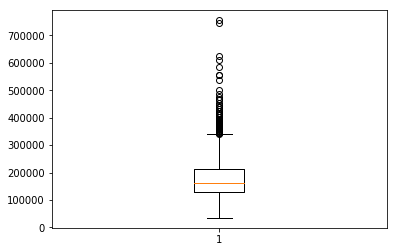

In [34]:
plt.boxplot(DataFrame1.SalePrice)


In [40]:
#DataFrame1 = DataFrame1.drop(DataFrame1[DataFrame1.SalePrice > 700000])
DataFrame1 = DataFrame1[DataFrame1.SalePrice < 700000]
DataFrame1[DataFrame1.SalePrice > 500000]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
178,179,20,RL,63.0,17423,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,StoneBr,Norm,Norm,1Fam,1Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,748.0,Ex,TA,PConc,Ex,TA,No,GLQ,1904,Unf,0,312,2216,GasA,Ex,Y,SBrkr,2234,0,0,2234,1,0,2,0,1,1,Ex,9,Typ,1,Gd,Attchd,2009.0,Fin,3,1166,TA,TA,Y,0,60,0,0,0,0,NaN,NaN,NaN,0,7,2009,New,Partial,501837
440,441,20,RL,105.0,15431,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,10,5,2008,2008,Hip,CompShg,VinylSd,VinylSd,Stone,200.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,1767,ALQ,539,788,3094,GasA,Ex,Y,SBrkr,2402,0,0,2402,1,0,2,0,2,1,Ex,10,Typ,2,Gd,Attchd,2008.0,Fin,3,672,TA,TA,Y,0,72,0,0,170,0,NaN,NaN,NaN,0,4,2009,WD,Normal,555000
769,770,60,RL,47.0,53504,Pave,NaN,IR2,HLS,AllPub,CulDSac,Mod,StoneBr,Norm,Norm,1Fam,2Story,8,5,2003,2003,Hip,CompShg,CemntBd,Wd Shng,BrkFace,603.0,Ex,TA,PConc,Gd,TA,Gd,ALQ,1416,Unf,0,234,1650,GasA,Ex,Y,SBrkr,1690,1589,0,3279,1,0,3,1,4,1,Ex,12,Mod,1,Gd,BuiltIn,2003.0,Fin,3,841,TA,TA,Y,503,36,0,0,210,0,NaN,NaN,NaN,0,6,2010,WD,Normal,538000
803,804,60,RL,107.0,13891,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,2Story,9,5,2008,2009,Hip,CompShg,VinylSd,VinylSd,Stone,424.0,Ex,TA,PConc,Ex,TA,Gd,Unf,0,Unf,0,1734,1734,GasA,Ex,Y,SBrkr,1734,1088,0,2822,0,0,3,1,4,1,Ex,12,Typ,1,Gd,BuiltIn,2009.0,RFn,3,1020,TA,TA,Y,52,170,0,0,192,0,NaN,NaN,NaN,0,1,2009,New,Partial,582933
898,899,20,RL,100.0,12919,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,NridgHt,Norm,Norm,1Fam,1Story,9,5,2009,2010,Hip,CompShg,VinylSd,VinylSd,Stone,760.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,2188,Unf,0,142,2330,GasA,Ex,Y,SBrkr,2364,0,0,2364,1,0,2,1,2,1,Ex,11,Typ,2,Gd,Attchd,2009.0,Fin,3,820,TA,TA,Y,0,67,0,0,0,0,NaN,NaN,NaN,0,3,2010,New,Partial,611657
1046,1047,60,RL,85.0,16056,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,StoneBr,Norm,Norm,1Fam,2Story,9,5,2005,2006,Hip,CompShg,CemntBd,CmentBd,Stone,208.0,Gd,TA,PConc,Ex,TA,Av,GLQ,240,Unf,0,1752,1992,GasA,Ex,Y,SBrkr,1992,876,0,2868,0,0,3,1,4,1,Ex,11,Typ,1,Gd,BuiltIn,2005.0,Fin,3,716,TA,TA,Y,214,108,0,0,0,0,NaN,NaN,NaN,0,7,2006,New,Partial,556581
1169,1170,60,RL,118.0,35760,Pave,NaN,IR1,Lvl,AllPub,CulDSac,Gtl,NoRidge,Norm,Norm,1Fam,2Story,10,5,1995,1996,Hip,CompShg,HdBoard,HdBoard,BrkFace,1378.0,Gd,Gd,PConc,Ex,TA,Gd,GLQ,1387,Unf,0,543,1930,GasA,Ex,Y,SBrkr,1831,1796,0,3627,1,0,3,1,4,1,Gd,10,Typ,1,TA,Attchd,1995.0,Fin,3,807,TA,TA,Y,361,76,0,0,0,0,NaN,NaN,NaN,0,7,2006,WD,Normal,625000


In [36]:
pd.set_option('display.max_columns', 500)

In [236]:
DataFrame = pd.read_csv(r'C:\Users\mohit\Downloads/train.csv')
test = pd.read_csv(r'C:\Users\mohit\Downloads/test.csv')
DataFrame = DataFrame[DataFrame.SalePrice < 700000]
DataFrame = DataFrame[DataFrame.LotFrontage != 313.0]
DataFrame = DataFrame[DataFrame.LotArea < 200000]
DataFrame = DataFrame[DataFrame.BsmtFinSF1 < 5000]
DataFrame = DataFrame[DataFrame.BsmtFinSF2 < 1400]
DataFrame = DataFrame[DataFrame.TotalBsmtSF< 6000]
DataFrame = DataFrame[DataFrame['1stFlrSF']< 4000]


#DataFrame.MSSubClass.astype('category').unique()
#test.MSSubClass.astype('category').unique()
sales = pd.DataFrame()
sales['Id'] = DataFrame['Id']
sales['SalesPrice']=DataFrame['SalePrice']
DataFrame = DataFrame.drop( columns=['SalePrice','Id'])
test = test.drop( columns=['Id'])
full_data = pd.concat([DataFrame,test], ignore_index=True)
sales['SalesPrice'] = np.log1p(sales.SalesPrice.values)

numeric_feats = full_data.dtypes[full_data.dtypes != "object"].index

# Check the skew of all numerical features
skewed_feats = full_data[numeric_feats].apply(lambda x: skew(x.dropna())).sort_values(ascending=False)
print("\nSkew in numerical features: \n")
skewness = pd.DataFrame({'Skew' :skewed_feats})
skewness = skewness[abs(skewness) > 0.75]
print("There are {} skewed numerical features to Box Cox transform".format(skewness.shape[0]))

from scipy.special import boxcox1p
skewed_features = skewness.index
lam = 0.15
for feat in skewed_features:
    full_data[feat] = boxcox1p(full_data[feat], lam)
    

full_data[full_data.columns[full_data.dtypes == 'object']]=full_data[
    full_data.columns[full_data.dtypes == 'object']].astype('category')

full_data.YearBuilt = full_data.YearBuilt.astype('category')
full_data.YearRemodAdd = full_data.YearRemodAdd.astype('category')

full_data['Exterior1st'] = full_data.Exterior1st.fillna(full_data.Exterior1st.value_counts().idxmax())
full_data['Exterior2nd'] = full_data.Exterior1st.fillna(full_data.Exterior2nd.value_counts().idxmax())

value = (full_data.LotFrontage/full_data.LotArea).mean()
full_data['LotFrontage'] = full_data.LotFrontage.fillna(value*full_data['LotArea'])

full_data.Utilities = full_data.Utilities.astype('category')
full_data['Utilities'] = full_data.Utilities.fillna(full_data.Utilities.value_counts().idxmax())


full_data.MasVnrType = full_data.MasVnrType.fillna('None')

full_data.MasVnrArea = full_data.MasVnrArea.fillna(0.0)

full_data.ExterCond = full_data.ExterCond.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data.ExterQual = full_data.ExterQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data.BsmtCond = full_data.BsmtCond.cat.add_categories(['None'])
full_data.BsmtCond = full_data.BsmtCond.fillna('None')


full_data.BsmtCond = full_data.BsmtCond.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})


full_data.BsmtQual = full_data.BsmtQual.cat.add_categories(['None'])
full_data.BsmtQual = full_data.BsmtQual.fillna('None')
full_data.BsmtQual = full_data.BsmtQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})


full_data.BsmtExposure = full_data.BsmtExposure.cat.add_categories(['None'])
full_data.BsmtExposure = full_data.BsmtExposure.fillna('None')
full_data.BsmtExposure = full_data.BsmtExposure.map({'Gd':4, 'Av':3, 'Mn':2, 'No':1, 'None':0})


full_data.BsmtFinType1 = full_data.BsmtFinType1.cat.add_categories(['None'])
full_data.BsmtFinType1 = full_data.BsmtFinType1.fillna('None')
full_data.BsmtFinType1 = full_data.BsmtFinType1.map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'None':0, 'LwQ':2, 'Unf':1})


full_data.BsmtFinType1 = full_data.BsmtFinType1.fillna(0)
full_data.BsmtFinSF2 = full_data.BsmtFinSF2.fillna(0)
full_data.BsmtUnfSF = full_data.BsmtUnfSF.fillna(0)
full_data.TotalBsmtSF = full_data.TotalBsmtSF.fillna(0)

full_data.BsmtFinType2 = full_data.BsmtFinType2.cat.add_categories(['None'])
full_data.BsmtFinType2 = full_data.BsmtFinType2.fillna('None')
full_data.BsmtFinType2 = full_data.BsmtFinType2.map({'GLQ':6, 'ALQ':5, 'BLQ':4, 'Rec':3, 'None':0, 'LwQ':2, 'Unf':1})


full_data.HeatingQC = full_data.HeatingQC.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data.Electrical = full_data.Electrical.map({'SBrkr':5, 'FuseA':2, 'FuseF':4, 'FuseP':3, 'Mix':1})

full_data['BsmtFullBath'] = full_data['BsmtFullBath'].fillna(0)  
full_data['BsmtHalfBath'] = full_data['BsmtHalfBath'].fillna(0)  
full_data.KitchenQual = full_data.KitchenQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1})

full_data['Functional']=full_data['Functional'].fillna(full_data.Functional.value_counts().idxmax())

full_data = full_data.drop(columns= ['Alley','FireplaceQu','Fence','MiscFeature','MasVnrArea'
                                    ,'PoolQC','Utilities','Condition2'])

full_data.GarageType = full_data.GarageType.cat.add_categories(['None'])
full_data.GarageType = full_data.GarageType.fillna('None')

full_data.GarageYrBlt = full_data.GarageYrBlt.fillna(0)
full_data.GarageYrBlt = full_data.GarageYrBlt.astype('category')

full_data.GarageFinish = full_data.GarageFinish.cat.add_categories(['None'])
full_data.GarageFinish = full_data.GarageFinish.fillna('None')
full_data.GarageFinish = full_data.GarageFinish.map({'Fin':3, 'RFn':2, 'Unf':1, 'None':0})

full_data.GarageQual = full_data.GarageQual.cat.add_categories(['None'])
full_data.GarageQual = full_data.GarageQual.fillna('None')
full_data.GarageQual = full_data.GarageQual.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})

full_data.GarageCond = full_data.GarageCond.cat.add_categories(['None'])
full_data.GarageCond = full_data.GarageCond.fillna('None')
full_data.GarageCond = full_data.GarageCond.map({'Ex':5, 'Fa':2, 'Gd':4, 'TA':3, 'Po':1, 'None':0})

full_data['MSZoning']=full_data['MSZoning'].fillna(full_data.MSZoning.value_counts().idxmax())

full_data.BsmtFinSF1 = full_data.BsmtFinSF1.fillna(0)
full_data['Electrical']=full_data['Electrical'].fillna(full_data.Electrical.value_counts().idxmax())
full_data['KitchenQual']=full_data['KitchenQual'].fillna(full_data.KitchenQual.value_counts().idxmax())

#full_data['PoolQC'] = full_data['PoolQC'].cat.add_categories(['None'])
#full_data['PoolQC'] =full_data['PoolQC'].fillna('None')

full_data.GarageCars = full_data.GarageCars.fillna(0)
full_data.GarageArea = full_data.GarageArea.fillna(0)

full_data.MoSold = full_data.MoSold.astype('category')

full_data.YrSold = full_data.YrSold.astype('category')
full_data['SaleType']=full_data['SaleType'].fillna(full_data.SaleType.value_counts().idxmax())



dum_full = pd.get_dummies(full_data)

train_split = dum_full[:len(DataFrame)]
test_split = dum_full[len(DataFrame):]



lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
ENet = make_pipeline(RobustScaler(), ElasticNet(alpha=0.0005, l1_ratio=.9, random_state=3))
KRR = KernelRidge(alpha=0.6, kernel='polynomial', degree=2, coef0=2.5)
GBoost = GradientBoostingRegressor(n_estimators=3000, learning_rate=0.05,
                                   max_depth=4, max_features='sqrt',
                                   min_samples_leaf=15, min_samples_split=10, 
                                   loss='huber', random_state =5)

#train_, test_, train_y, test_y = train_test_split(train_split.values,sales.SalesPrice.values,
#                                                            test_size = .10, random_state = 42)
kfold = KFold(n_splits=4, shuffle=True, random_state=42)



Skew in numerical features: 

There are 36 skewed numerical features to Box Cox transform


In [ ]:
0.9285654682436991 before removing  MasVnrArea and after removing all outlinears
0.9308318121505559 after removing MasVnrArea
0.9271011984937599 when you remove street
0.92 when removed utilities but I will remove it because there is only 1
0.9289706971641241 when removed 2 condition
0.9280968831025174 when removed only2nd co
0.9279818117567237 when removed RoofMatl
0.925 when 5 split
0.921 when 3 split
0.92when removed from removed ,'Utilities','Condition2'
0.921 when replace none in poolqc
0.925 when everything was as before
0.923 when KKN at place of lasso
0.9455298949742884 after all this

In [213]:
from sklearn.kernel_ridge import KernelRidge

In [240]:
np.mean(met_creat, axis=1)

array([11.74486895, 11.67072083, 11.29197476, ..., 12.34747019,
       11.87125037, 11.84088889])

In [ ]:
models = [KRR,ENet, GBoost]
met_creat = np.zeros((len(train_),len(models)))
for i, model in enumerate(models):
    for train_index,hold_out in kfold.split(train_,train_y):
        model.fit(train_[train_index],train_y[train_index])
        predy = model.predict(train_[hold_out])
        met_creat[hold_out,i] = predy
lasso_meta = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso_meta.fit(np.mean(met_creat, axis=1),train_y)
meta_features = np.column_stack([model.predict(test_) for model in models])
meta_features=np.mean(meta_features, axis=1)
pred_final=lasso_meta.predict(meta_features)

print(r2_score(test_y,pred_final))

In [237]:
#when final copy need
models = [KRR,ENet, GBoost]
met_creat = np.zeros((len(train_split),len(models)))
for i, model in enumerate(models):
    for train_index,hold_out in kfold.split(train_split.values,sales.SalesPrice.values):
        model.fit(train_split.values[train_index],sales.SalesPrice.values[train_index])
        predy = model.predict(train_split.values[hold_out])
        met_creat[hold_out,i] = predy
lasso_meta = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
lasso_meta.fit(met_creat,sales.SalesPrice.values)
meta_features = np.column_stack([model.predict(test_split) for model in models])
pred_final=lasso_meta.predict(meta_features)

#print(r2_score(test_y,pred_final))

In [227]:
meta_features = np.column_stack([model.predict(test_split) for model in models])
meta_features=np.mean(meta_features, axis=1)
pred_final=lasso_meta.predict(meta_features)

1459

In [238]:
res=np.expm1(pred_final)
res=pd.DataFrame(res)
res.to_csv('predictions_4.csv', encoding='utf-8')



In [ ]:
full_Data['PoolQC'].fill

In [204]:
DataFrame = pd.read_csv(r'C:\Users\mohit\Downloads/train.csv')
print(DataFrame['PoolQC'].value_counts())
DataFrame['PoolQC'] =DataFrame['PoolQC'].fillna('None')
print(DataFrame['PoolQC'].value_counts())


Gd    3
Ex    2
Fa    2
Name: PoolQC, dtype: int64
None    1453
Gd         3
Ex         2
Fa         2
Name: PoolQC, dtype: int64


In [111]:
DataFrame1 = DataFrame[pd.notnull(DataFrame['MasVnrArea'])]

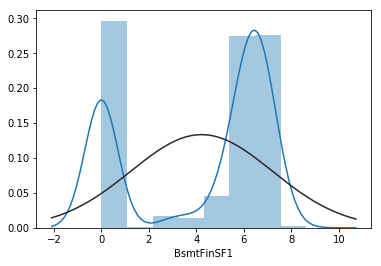

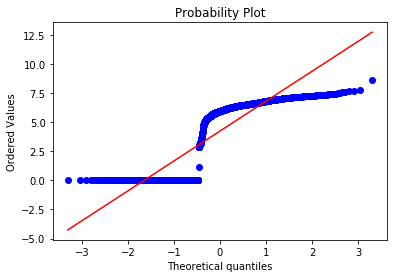

In [117]:
#DataFrame.LotFrontage.dropna()
sns.distplot(np.log1p(DataFrame1.BsmtFinSF1) , fit=norm)
fig = plt.figure()
res = stats.probplot(np.log1p(DataFrame1.BsmtFinSF1), plot=plt)
plt.show()

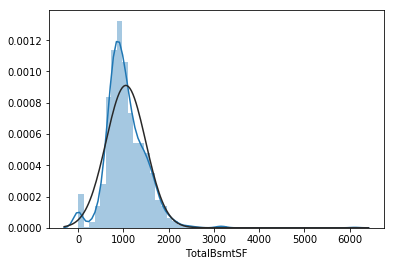

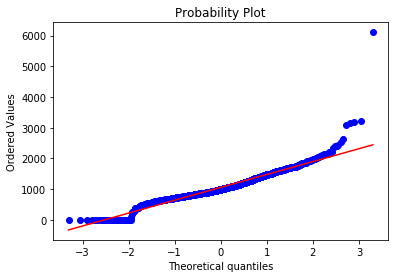

In [127]:

sns.distplot(DataFrame1.TotalBsmtSF , fit=norm)
fig = plt.figure()
res = stats.probplot(DataFrame1.TotalBsmtSF, plot=plt)
plt.show()

C:\Users\mohit\Anaconda3\envs\House_price_prediction\lib\site-packages\numpy\lib\function_base.py:3652: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)
C:\Users\mohit\Anaconda3\envs\House_price_prediction\lib\site-packages\matplotlib\cbook\__init__.py:1246: RuntimeWarning: invalid value encountered in less_equal
  wiskhi = np.compress(x <= hival, x)
C:\Users\mohit\Anaconda3\envs\House_price_prediction\lib\site-packages\matplotlib\cbook\__init__.py:1253: RuntimeWarning: invalid value encountered in greater_equal
  wisklo = np.compress(x >= loval, x)
C:\Users\mohit\Anaconda3\envs\House_price_prediction\lib\site-packages\matplotlib\cbook\__init__.py:1261: RuntimeWarning: invalid value encountered in less
  np.compress(x < stats['whislo'], x),
C:\Users\mohit\Anaconda3\envs\House_price_prediction\lib\site-packages\matplotlib\cbook\__init__.py:1262: RuntimeWarning: invalid value encountered in greater
  np.compress(x > stats['whishi'], x)


{'whiskers': [<matplotlib.lines.Line2D at 0x20ab8a3e6a0>,
 'caps': [<matplotlib.lines.Line2D at 0x20ab8a3ec88>,
 'boxes': [<matplotlib.lines.Line2D at 0x20ab8a3e2b0>],
 'medians': [<matplotlib.lines.Line2D at 0x20ab8a35160>],
 'fliers': [<matplotlib.lines.Line2D at 0x20ab8a354a8>],
 'means': []}

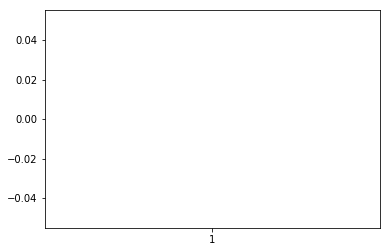

In [154]:
plt.boxplot(DataFrame['LotFrontage'])

In [151]:
DataFrame = pd.read_csv(r'C:\Users\mohit\Downloads/train.csv')
DataFrame[(DataFrame.LotFrontage > 200) ]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
934,935,20,RL,313.0,27650,Pave,NaN,IR2,HLS,AllPub,Inside,Mod,NAmes,PosA,Norm,1Fam,1Story,7,7,1960,2007,Flat,Tar&Grv,Wd Sdng,Wd Sdng,None,0.0,TA,TA,CBlock,Gd,TA,Gd,GLQ,425,Unf,0,160,585,GasA,Ex,Y,SBrkr,2069,0,0,2069,1,0,2,0,4,1,Gd,9,Typ,1,Gd,Attchd,1960.0,RFn,2,505,TA,TA,Y,0,0,0,0,0,0,NaN,NaN,NaN,0,11,2008,WD,Normal,242000
1298,1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,Gtl,Edwards,Feedr,Norm,1Fam,2Story,10,5,2008,2008,Hip,ClyTile,Stucco,Stucco,Stone,796.0,Ex,TA,PConc,Ex,TA,Gd,GLQ,5644,Unf,0,466,6110,GasA,Ex,Y,SBrkr,4692,950,0,5642,2,0,2,1,3,1,Ex,12,Typ,3,Gd,Attchd,2008.0,Fin,2,1418,TA,TA,Y,214,292,0,0,0,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000
